In [ ]:
!pip install -U transformers==4.30.0

import math
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
from torch import nn, Tensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable
import numpy as np
from torch.utils.data import Dataset, DataLoader
import random
from sklearn.metrics import r2_score, mean_squared_error
from torch.optim.lr_scheduler import StepLR
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerModel, TimeSeriesTransformerForPrediction


from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.2 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
path = "drive/MyDrive/feature1.csv"
df = pd.read_csv(path)
df.columns

Index(['Dati', 'Time', 'DEPTH', 'ENGINE_1_FLOWTEMPA',
       'ENGINE_1_FUEL_CONSUMPTION', 'ENGINE_2_FLOWTEMPA',
       'ENGINE_2_FUEL_CONSUMPTION', 'HEADING', 'LATITUDE', 'LONGITUDE',
       'PITCH_1', 'PITCH_2', 'POWER_1', 'POWER_2', 'SOG', 'SOG_SPEEDLOG_LONG',
       'SOG_SPEEDLOG_TRANS', 'SPEED_1', 'SPEED_2', 'STW', 'THRUST_1',
       'THRUST_2', 'TORQUE_1', 'TORQUE_2', 'WIND_ANGLE', 'WIND_SPEED',
       'WIND_ANGLE_TRUE', 'WIND_SPEED_TRUE', 'trip_id', 'MODE', 'datetime',
       'season', 'weekday', 'current', 'direction', 'pressure', 'rain',
       'snowfall', 'weathercode', 'is_weekday', 'wind_force', 'wind_direc',
       'effective_wind_factor', 'effective_wind', 'resist_ratio1',
       'resist_ratio2', 'adversarial'],
      dtype='object')

In [ ]:
df["prev_long"] = df.LONGITUDE.shift(periods=1)
df["prev_lat"] = df.LATITUDE.shift(periods=1)
df["disp"] = ((df.LONGITUDE -  df.prev_long)**2 + (df.LATITUDE-df.prev_lat)**2)**(0.5)
df["prev_SOG"] = df.SOG.shift(periods=1)
df["acceleration"] = ((df.SOG - df.prev_SOG))
df["goal_long"] = df.direction.apply(lambda x: -123.2715 if x==1 else -123.9554)
df["goal_lat"] = df.direction.apply(lambda x: 49.3771 if x==1 else 49.1936)
df["start_long"] = df.direction.apply(lambda x: -123.2715 if x!=1 else -123.9554)
df["start_lat"] = df.direction.apply(lambda x: 49.3771 if x!=1 else 49.1936)
# distance to the destination
df["distance_d"] = ((df["goal_long"]-df["LONGITUDE"])**2 + \
                             (df["goal_lat"]-df["LATITUDE"])**2 )**0.5
# distance from the starting point
df["distance_s"] = ((df["goal_long"]-df["LONGITUDE"])**2 + \
                             (df["goal_lat"]-df["LATITUDE"])**2 )**0.5
df["prev_HEADING"] = df.HEADING.shift(periods=1)
df["turn"] = df.HEADING - df.prev_HEADING


In [ ]:
df["POWER"] = (df["POWER_1"]+df["POWER_2"])/2
df["SPEED"] = (df["SPEED_1"]+df["SPEED_2"])/2
df["THRUST"] = (df["THRUST_1"]+df["THRUST_2"])/2
df["TORQUE"] = (df["TORQUE_1"]+df["TORQUE_2"])/2
df["PITCH"] = (df["PITCH_1"]+df["PITCH_2"])/2
df["resist_ratio"] = (df["resist_ratio1"]+df["resist_ratio2"])/2
df["FLOWTEMPA"] = (df["ENGINE_1_FLOWTEMPA"]+df["ENGINE_2_FLOWTEMPA"])/2
df["FC"] = (df["ENGINE_1_FUEL_CONSUMPTION"]+df["ENGINE_2_FUEL_CONSUMPTION"])/2

df = df.drop(['PITCH_1', 'PITCH_2', 'POWER_1', 'POWER_2', 'SOG_SPEEDLOG_LONG',
       'SOG_SPEEDLOG_TRANS',  'THRUST_1',
       'THRUST_2', 'TORQUE_1', 'TORQUE_2', 'datetime',
       'resist_ratio1', 'resist_ratio2', 'SPEED_1', 'SPEED_2',
       'ENGINE_1_FLOWTEMPA', 'ENGINE_2_FLOWTEMPA',
       "ENGINE_1_FUEL_CONSUMPTION", "ENGINE_2_FUEL_CONSUMPTION"], axis=1)
# df = df.drop(["FLOWTEMPA", "PITCH", "POWER", "effective_wind_factor", "THRUST",
              # "pressure", "weekday", "Dati",], axis=1)
df["direction"] = df["direction"].apply(lambda x: 1 if x=="N-H" else 0)
df["MODE"] = df["MODE"].apply(lambda x: x-1)
# df = df[df["adversarial"]==0].drop("adversarial", axis=1)
# df = df[df["direction"]==1].drop("direction", axis=1)
df["Time2"] = df.groupby("trip_id")["Time"].rank(method="first", ascending=True)

In [ ]:
# get one_hot for column
def one_hot(df, cols, normalize = True):
    for col in cols:
        dummy = pd.get_dummies(df[col],prefix=col, drop_first=True)
        columns = dummy.columns
        dummy[col] = 0
        i = 1
        for x in columns:
            # dummy["tmp"] = dummy[col]
            dummy[col] = dummy[col] + dummy[x]*i
            i = i*2
        max = dummy[col].max()
        if normalize:
            df[col] = dummy[col] / max
        else:
            df[col] = dummy[col]
    return df

In [ ]:
# standard scaler
scaler1 = StandardScaler()
scaler2 = MinMaxScaler()
transform_cols = [ x for x in df.columns if (x not in ["MODE", "is_weekday", "direction", "season", "weathercode", "beaufort_score", "trip_id", "wind_direc"])]
df[transform_cols] = scaler2.fit_transform(df[transform_cols])
df[transform_cols] = scaler1.fit_transform(df[transform_cols])
# transform_cols
df = one_hot(df, ["season", "weathercode", "wind_direc"])


In [ ]:
df["is_weekday"] = df["is_weekday"].apply(lambda x: 1 if x==True else 0)

In [ ]:




#  ----------------- train -------------------
# x_cols = ['Time',
#        'FC', "turn", "LATITUDE", 'LONGITUDE', 'SOG',
#        'MODE', "DEPTH", 'current',
#        'rain', 'snowfall',
#        "acceleration", 'is_weekday',
#        'wind_force', 'wind_direc',
#        'direction', 'adversarial',
#       #  'effective_wind',
#        'TORQUE', 'resist_ratio',
#        "season", #"weathercode",
#         'disp', "distance_s", "distance_d"]



In [ ]:
class vessel_data(Dataset):
    def __init__(self, train = True, test=False, train_test_split = 0.7, rand_seed=1):
        ##########################inputs##################################
        #data_dir(string) - directory of the data#########################
        #size(int) - size of the images you want to use###################
        #train(boolean) - train data or test data#########################
        #train_test_split(float) - the portion of the data for training###
        #augment_data(boolean) - use data augmentation or not#############
        super(vessel_data, self).__init__()
        # todo
        #initialize the data class
        trips = list(df.trip_id.unique())
        self.train = train
        self.sequence_length = sequence_length
        self.prediction_horizon = prediction_horizon

        # train_test_split
        random.seed(rand_seed)
        train_size = int(np.ceil(len(trips)*train_test_split))
        train_trips = random.sample(trips, k=train_size)
        if train:
            self.trips_id = train_trips
        else:
            test_trips = [ x for x in trips if x not in train_trips]
            valid_trips = random.sample(test_trips, k = int(np.ceil(len(trips)*((1-train_test_split)*.7))))
            if test==False:
                self.trips_id = valid_trips
            else:
                self.trips_id = [ x for x in test_trips if x not in valid_trips]
        self.starting_dict = self.get_starting(df)

    # convert a df to tensor
    def df_to_tensor(self, df):
        if torch.cuda.is_available():
            device = torch.device('cuda:0')
        else:
            device = torch.device('cpu')
        return torch.from_numpy(df.values.astype("float")).float().to(device)

    def get_starting(self, df):
        starting_dict = {}
        for trip_id in self.trips_id:
            data = df[df.trip_id==trip_id].reset_index(drop=True)
            starting = random.randint(0, len(data)-91)
            starting_dict[trip_id] = starting
            # print(starting)
        # print(starting_dict)
        return starting_dict

    def __getitem__(self, idx):
        #load corresponding trip id from index idx of your data
        trip_id = (self.trips_id[idx//3])
        start = self.starting_dict[trip_id]
        start_idx = self.starting_dict[trip_id] + (idx%3)*(self.prediction_horizon+self.sequence_length)
        data = df[df.trip_id==trip_id].reset_index(drop=True)
        #get the needed episodes from the trips
        end_idx = start_idx + self.sequence_length

        past_values = data.iloc[start_idx : end_idx][y_cols]
        past_time_features = data.iloc[start_idx : end_idx][time_feature + dynamic_real_feature]
        static_categorical_features = data.iloc[0][static_real_feature]
        future_values = data.iloc[end_idx : (end_idx + self.prediction_horizon)][y_cols]
        future_time_features = data.iloc[end_idx : (end_idx + self.prediction_horizon)][time_feature + dynamic_real_feature]
        # static_categorical_features = torch.from_numpy(static_categorical_features.values.astype("int8")).int().to(device)

        return self.df_to_tensor(past_values), self.df_to_tensor(past_time_features), self.df_to_tensor(static_categorical_features), \
               self.df_to_tensor(future_values), self.df_to_tensor(future_time_features)

    def __len__(self):
        return len(self.trips_id) * 3

In [ ]:
time_feature = ["Time2"]
dynamic_real_feature = ["MODE", "DEPTH", 'current', "turn", "TORQUE", "SPEED",
       'rain', 'snowfall', "pressure", "acceleration", 'wind_force', 'wind_direc', 'resist_ratio', 'disp', "distance_s", "distance_d",
       'FC', "HEADING", "turn", "LATITUDE", 'LONGITUDE', 'STW']
static_real_feature = ["is_weekday", 'direction', 'adversarial', "season",]
y_cols = ['FC', "LATITUDE", 'LONGITUDE', 'STW'， "MODE", "DEPTH", 'current', ]


if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

batch_size=128
lr = 1e-3
sequence_length = 25
context_length = 18
prediction_horizon = 5
n_epochs = 50
# criterion = Weighted_Loss()

In [ ]:
# MODEL
configuration = TimeSeriesTransformerConfig(prediction_length=prediction_horizon,
        context_length=context_length, input_size=len(y_cols), num_time_features=len(time_feature),
        num_dynamic_real_features = len(dynamic_real_feature), num_static_real_features = len(static_real_feature),
        # cardinality = cardinality,
        return_dict = True)
model = TimeSeriesTransformerForPrediction(configuration).cuda()


optimizer = torch.optim.Adam(model.parameters(), lr=lr)
trainset = vessel_data(train = True, train_test_split = 0.8, rand_seed=1)
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle=True, drop_last=True)

testset = vessel_data(train = False, train_test_split = 0.8, rand_seed=1)
validloader = DataLoader(testset, batch_size = batch_size, drop_last=True)



In [ ]:
# train the model
def train_model(trainloader, testloader, model, model_name = "transformer"):
    for epoch in range(n_epochs):
        epoch_loss = 0
        model.train()
        for i, data in enumerate(trainloader):
            past_values, past_time_features, static_real_features, future_values, future_time_features  = data
            optimizer.zero_grad()
            past_observed_mask = torch.ones(past_values.shape).to(device)

            prediction = model(past_values=past_values, past_time_features=past_time_features, static_real_features=static_real_features,
                               past_observed_mask=past_observed_mask, future_values=future_values, future_time_features=future_time_features,
                               output_hidden_states=True)
            # print(prediction.__attritubes__)
            # print(future_values.shape)
            # print(prediction.loss)
            # loss = criterion(prediction.get("logits"), future_values)
            loss = prediction.loss
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()

        print('Epoch %d / %d --- Loss: %.8f' % (epoch, n_epochs, epoch_loss / len(trainloader)))
        mse, r2= evaluate_model(testloader, model)
        print('valid error: MSE: {}'.format(mse))
        print('valid r2: {}'.format(r2))
        path = "drive/MyDrive/{}_checkpoint{}.pt".format(model_name, epoch)
        torch.save(model.state_dict(), path)
    # path = "drive/MyDrive/{}_final.pt".format(model_name, n_epochs)
    # torch.save(model.state_dict(), path)


# evaluate the model
def evaluate_model(testloader, model, mode="valid", i=0):
    model.eval()
    to_draw = []
    predictions = []
    actuals = []
    i_val = i
    with torch.no_grad():
      for i, data in enumerate(testloader):
          past_values, past_time_features, static_real_features, future_values, future_time_features  = data
          past_observed_mask = torch.ones(past_values.shape).to(device)
          outputs = model.generate(past_values=past_values, past_time_features=past_time_features, static_real_features=static_real_features,
                               past_observed_mask=past_observed_mask, future_time_features=future_time_features).sequences.mean(dim=1)
          # retrieve numpy array
          # print(outputs)
          yhat = outputs[:, :, i_val].detach().cpu().numpy()
          actual = future_values[:, :, i_val].detach().cpu().numpy()
          # store
          actual = actual.reshape([-1, 1])
          yhat = yhat.reshape([-1,1])
          # store
          predictions.append(yhat)
          actuals.append(actual)
          past = past_values[:,:,i_val].detach().cpu().numpy()
          actual = future_values[:,:, i_val].detach().cpu().numpy()
          predicted = outputs[:,:,i_val].detach().cpu().numpy()
          past_time = past_time_features[:,:, i_val].detach().cpu().numpy()
          pred_time = future_time_features[:,:, i_val].detach().cpu().numpy()

          to_draw.append({"past": past, "past_time":past_time, "acutal": actual, "predicted": predicted, "pred_time": pred_time})
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    if mode=="test":
      return mean_squared_error(actuals, predictions), r2_score(actuals, predictions), to_draw, predictions, actuals
    # calculate mse
    return mean_squared_error(actuals, predictions), r2_score(actuals, predictions)
    #actuals[:20], predictions[:20]

In [ ]:
model.load_state_dict(torch.load("drive/MyDrive/transformer5_5_checkpoint9.pt"))


<All keys matched successfully>

In [ ]:
iter = -1

In [ ]:
iter = iter+1
print(iter)
n_epochs = 10
batch_size= 128
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
train_model(trainloader, validloader, model, "transformer5_{}".format(iter))

In [ ]:
y_cols = ['FC', "HEADING", "LATITUDE", 'LONGITUDE', 'STW',]
testset = vessel_data(train = False, test=True, train_test_split = 0.8, rand_seed=1)
testloader = DataLoader(testset, batch_size = batch_size, drop_last=True)
#FC
evaluate_model(testloader, model, mode="valid")

(0.010520609, 0.984237559414071)

In [ ]:
#HEADING
evaluate_model(testloader, model, mode="valid", i=1)

(0.0006283957, 0.9951838023515833)

In [ ]:
#LATITUDE
evaluate_model(testloader, model, mode="valid", i=2)

(0.0008265516, 0.999000650543432)

In [ ]:
#LONGITUDE
evaluate_model(testloader, model, mode="valid", i=3)

(0.00078094646, 0.9990475924129709)

In [ ]:
#STW
evaluate_model(testloader, model, mode="valid", i=4)

(0.007927723, 0.974513801566133)

In [ ]:
# y_cols = ['FC', "HEADING", "LATITUDE", 'LONGITUDE', 'STW']


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.widgets import Slider, Button, RadioButtons


def plot(batch_i=0, seq_i=0):
  actual = np.concatenate([to_draw[batch_i]["past"][seq_i][[-1]], to_draw[batch_i]["acutal"][seq_i]])
  predicted = np.concatenate([to_draw[batch_i]["past"][seq_i][[-1]], to_draw[batch_i]["predicted"][seq_i]])
  plt.plot(to_draw[batch_i]["past"][seq_i], label='past'.format(i=0))
  plt.plot(range(24,30), actual, label='actual'.format(i=1))
  plt.plot(range(24,30), predicted, label='predicted'.format(i=2))
  plt.legend(loc='best')
  plt.show()

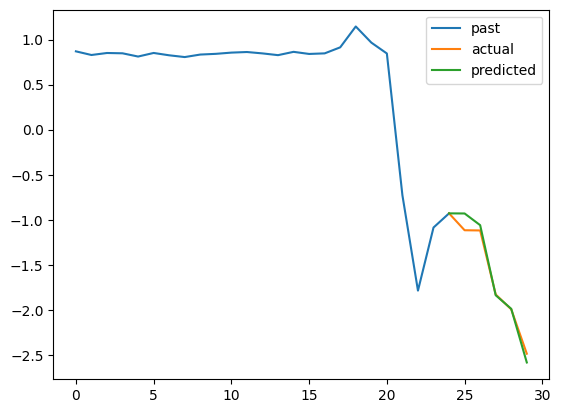

In [ ]:
_,_, to_draw, predictions, actuals = evaluate_model(testloader, model, mode="test", i=0)
# to_draw[0]

plot(batch_i=0, seq_i=2)
# plt.plot(to_draw[0]["past"][0], label='past'.format(i=0))


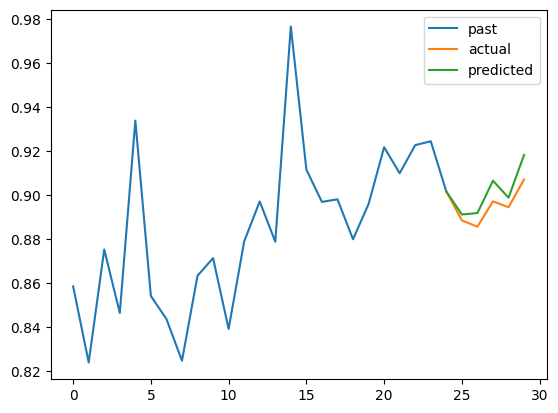

In [ ]:
plot(batch_i=0, seq_i=7)

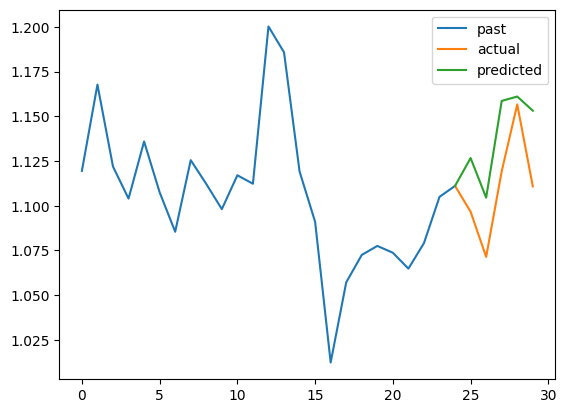

In [ ]:
plot(batch_i=1, seq_i=29)

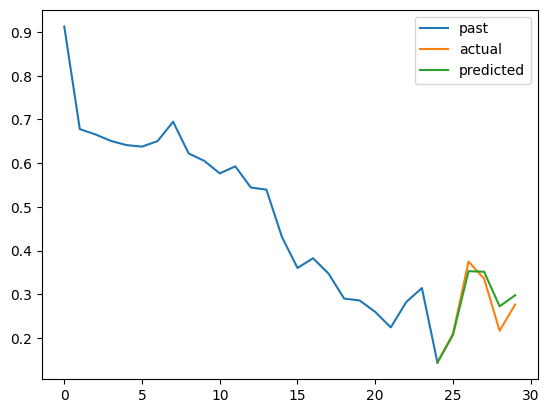

In [ ]:
plot(batch_i=0, seq_i=96)

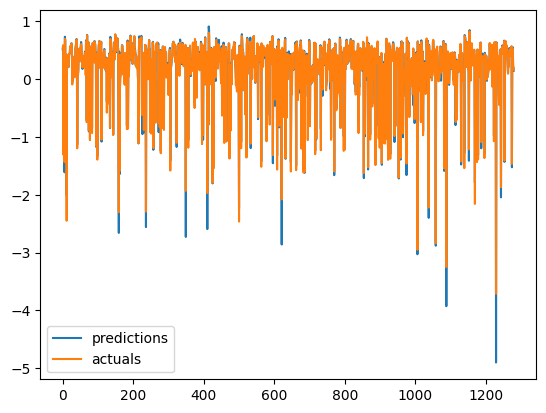

In [ ]:
_,_, to_draw, predictions, actuals = evaluate_model(testloader, model, mode="test", i=4)
# to_draw[0]

predictions, actuals

plt.plot(predictions, label='predictions'.format(i=2))
plt.plot(actuals, label='actuals'.format(i=1))
plt.legend(loc='best')
plt.show()

In [ ]:
# torch.save(model.state_dict(), "drive/MyDrive/time_series_transformers_best.pt")